<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/shosim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teorie hromadné obsluhy

## Krátké připomenutí
Kandalova notace

Systémy M/M/1, M/M/n

Pro systém M/M/1 platí rovnice o průměrné délce fronty

$L = \frac{\lambda}{\mu}$

kde L je  průměrná délka fronty

$\lambda$ je intenzita toku požadavků

$\mu$ je intenzita obsluhy

odkaz https://en.wikipedia.org/wiki/Queueing_theory

## Simulace toku požadavků

### Poisonův tok

Poisonův tok je model např. příchodu zákazníků k přepážce, kde jsou obsluhováni. Pro modelování potřebujeme generovat posloupnost příchodů. Interval mezi jednotlivými příchody lze generovat podle následujícího vztahu

$r'=-\frac{1}{\lambda}ln(r)$

kde $r$ je náhodné číslo s rovnoměrným rozložením a $r'$ je náhodný interval mezi dvěma příchody.

Stejným vztahem lze vypočítat náhodnou délku obsluhy (pro systémy M/M/1 nebo M/M/n)

https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/

In [1]:
from random import random
from math import log as ln

def rndEx(rnd, lam):
  x = rnd()
  result = (-1 / lam) * ln(x) #https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/
  return result

Text(0.5, 0, 'Čas')

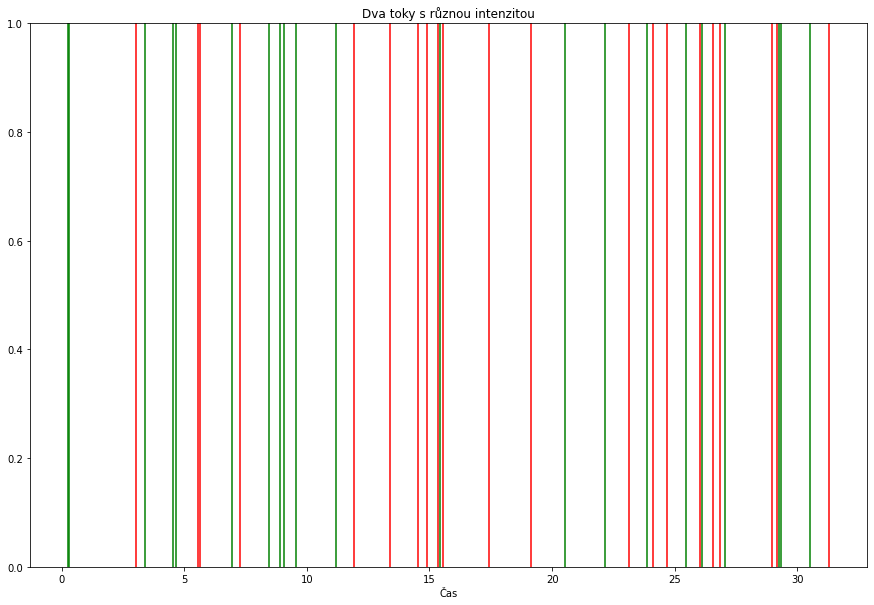

In [7]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

def plotFlow(maxTime, lam, color):
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    plt.axvline(x = currentTime, color =color)

plotFlow(30, 0.5, color='red')    
plotFlow(30, 1, color='green')    
plt.title('Dva toky s různou intenzitou')
plt.xlabel('Čas');